In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def ips(P,k,Lsurvey):
    '''
    P = power spectrum
    k = wavenumber-space points at which the power spectrum is sampled
    Lsurvey = length of a simulation cube side, in Mpc
    '''
    # helper variable setup
    k=k.real # nonzero imag part would be a mistake
    P=P.real # nonzero imag part would be a mistake
    Npix=len(P)
    assert(Npix%2==0)
    Delta = Lsurvey/Npix # voxel side length
    dr3 = Delta**3 # voxel volume
    twopi = 2*np.pi
    V=Lsurvey**3
    Nsamp=Npix**3
    r=twopi/(Lsurvey*k)
    
    # center-origin r grid    
    rgrid=np.zeros((Npix,Npix,Npix))
    rmags=np.arange(0,Lsurvey//2,Delta) # r magnitudes
    rmags=np.arange(-Lsurvey//2,Lsurvey//2,Delta) # r magnitudes
    for ii in range(Npix):
        for jj in range(Npix):
            for kk in range(Npix):
                rgrid[ii,jj,kk]=np.sqrt(rmags[ii]**2+rmags[jj]**2+rmags[kk]**2)
    
    # take appropriate draws from normal distributions to populate the real part of T-tilde
    sigmas=np.flip(np.sqrt(V*P/2)) # has Npix elements ... each element describes the T-tilde values in that k-bin ... flip to anticipate the fact that I'm working in r-space but calculated this vector in k-space
    Ttre=np.zeros((Npix,Npix,Npix)) # this & next - to hold the grid of T-tilde values
    binidxs=np.digitize(rgrid,r,right=False) # must pass x,bins; rgrid is the big box and r has floors
    for i,binedge in enumerate(r):
        sig=sigmas[i]
        here=np.nonzero(i==binidxs) # all box indices where the corresp bin index is the ith binedge (iterable)
        numhere=len(np.argwhere(i==binidxs)) # number of voxels in the bin we're currently considering
        samps=np.random.normal(scale=sig, size=(numhere,)) # samples for filling the current bin
        if (numhere>0):
            bef=len(np.argwhere(Ttre))
            Ttre[here]=samps 
    
    # use symmetry to popuate the imaginary part of T-tilde
    Ttim=np.zeros((Npix,Npix,Npix))
    Ttim[:,:,:Npix//2]=np.flip(Ttre[:,:,Npix//2:],axis=2)
    Ttim[:,:,Npix//2:]=np.flip(Ttre[:,:,:Npix//2],axis=2)
    
    # stitch together T-tilde from its populated components, and iffshift->ifftn->fftshift
    Tt=np.array(Ttre+1j*Ttim,dtype='complex')
    np.savetxt('check_Tt.txt',np.reshape(Tt,(Npix**3,)))
    Tts=np.fft.ifftshift(Tt) # bring the origin to the corner
    Ts=np.fft.ifftn(Tts) # inverse FT
    T=(np.fft.fftshift(Ts)/dr3).real # return the origin to the center and take T out of integral-land
    
    return rgrid,T
    

In [3]:
Lsurvey=100 # Mpc
kfl,P=np.genfromtxt('ps_wn_20px.txt',dtype='complex').T

In [4]:
rgen,Tgen=ips(P,kfl,Lsurvey)

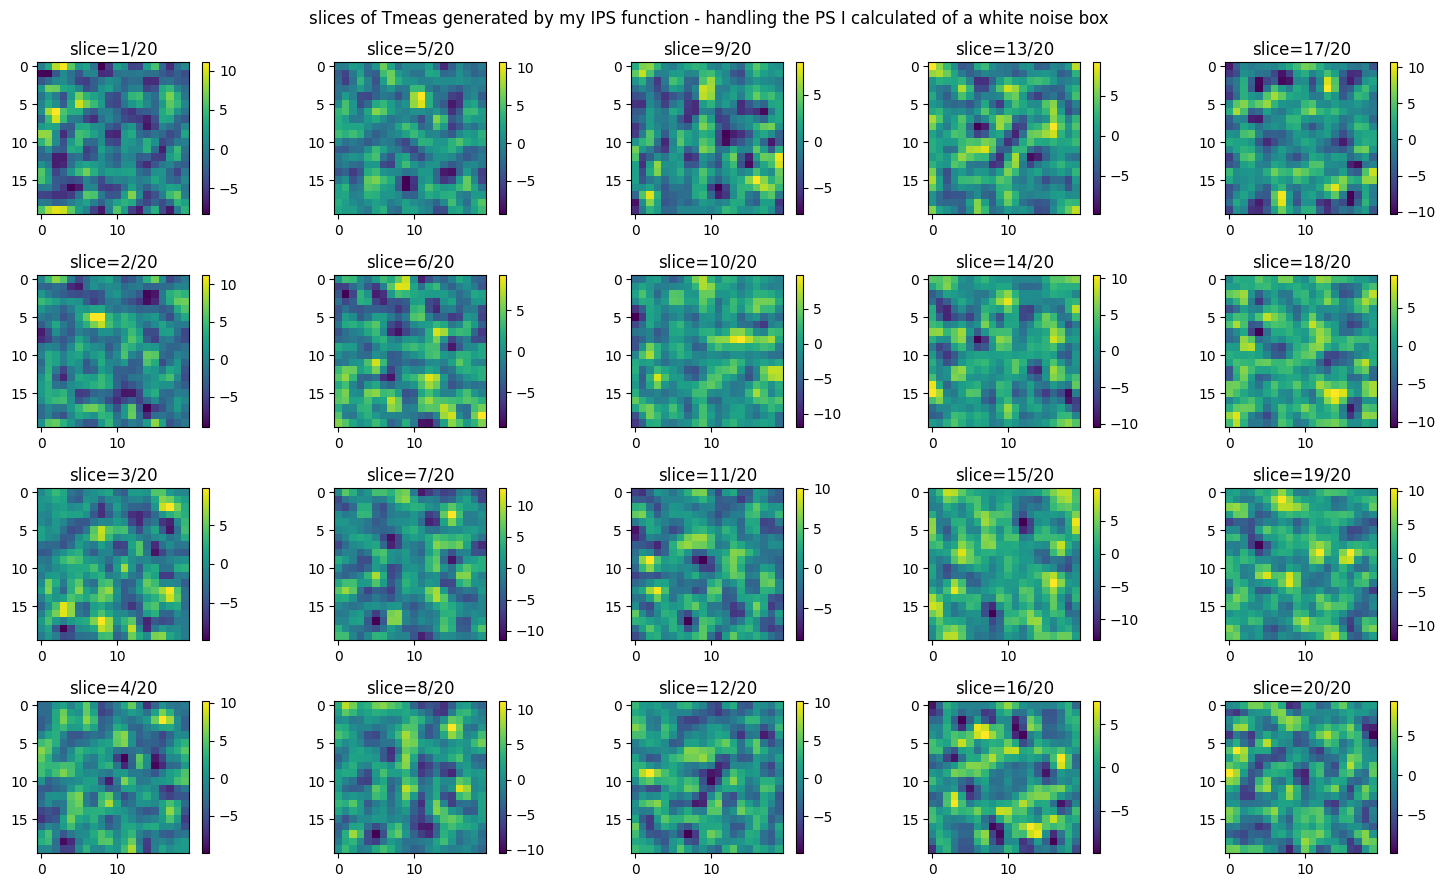

In [5]:
Npix=20 # hard-code b/c I know which generated power spectrum I'm dealing with
fig,axs=plt.subplots(4,5,figsize=(15,9))
for k in range(Npix):
    i=k%4
    j=k//4
    im=axs[i,j].imshow(Tgen[:,:,k])
    fig.colorbar(im)
    axs[i,j].set_title('slice='+str(k+1)+'/20')
plt.suptitle('slices of Tmeas generated by my IPS function - handling the PS I calculated of a white noise box')
plt.tight_layout()
plt.show()

what about averaging over all the slices?

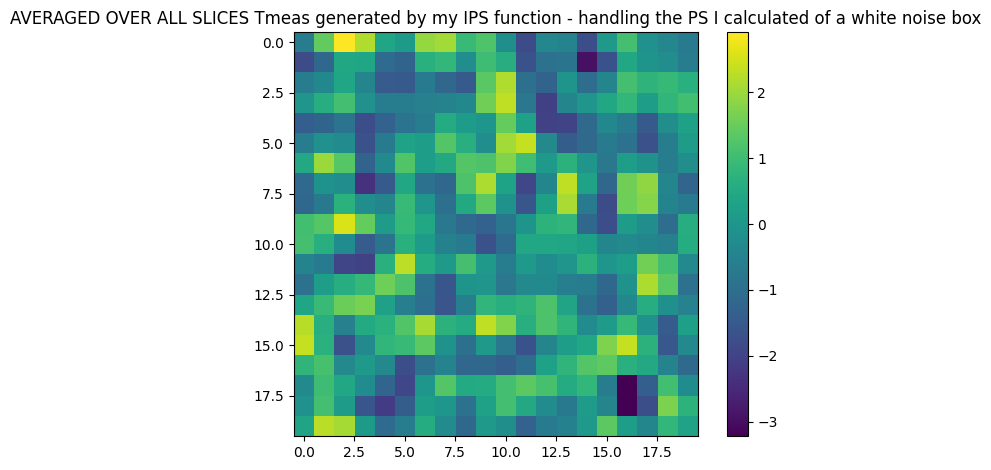

In [6]:
Tavg=np.mean(Tgen,axis=2)
plt.imshow(Tavg)
plt.colorbar()
plt.title('AVERAGED OVER ALL SLICES Tmeas generated by my IPS function - handling the PS I calculated of a white noise box')
plt.tight_layout()
plt.show()

average over several realizations

In [7]:
nrealiz=20
allT=[]
for i in range(nrealiz):
    rgen,Tgen=ips(P,kfl,Lsurvey)
    allT.append(Tgen)  
allT=np.array(allT)
print('allT.shape is',allT.shape)
meanT=np.mean(allT,axis=3) # average the brain-melting list of 3D arrays back down into a single 3d array

allT.shape is (20, 20, 20, 20)


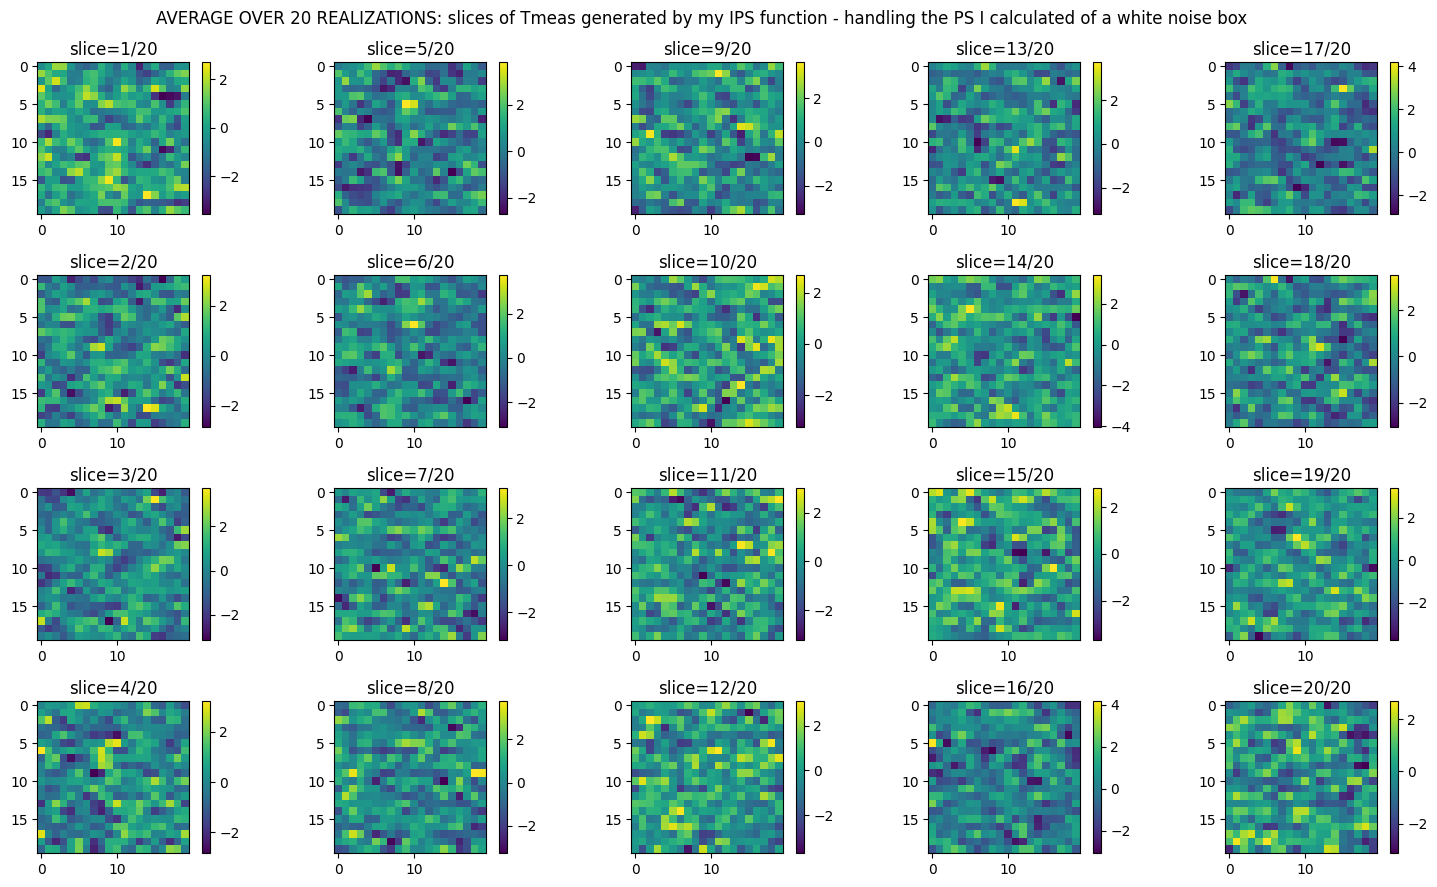

In [8]:
fig,axs=plt.subplots(4,5,figsize=(15,9))
for k in range(Npix):
    i=k%4
    j=k//4
    im=axs[i,j].imshow(meanT[:,:,k])
    fig.colorbar(im)
    axs[i,j].set_title('slice='+str(k+1)+'/20')
plt.suptitle('AVERAGE OVER '+str(nrealiz)+' REALIZATIONS: slices of Tmeas generated by my IPS function - handling the PS I calculated of a white noise box')
plt.tight_layout()
plt.show()

...and then average over all the slices on top of that?!

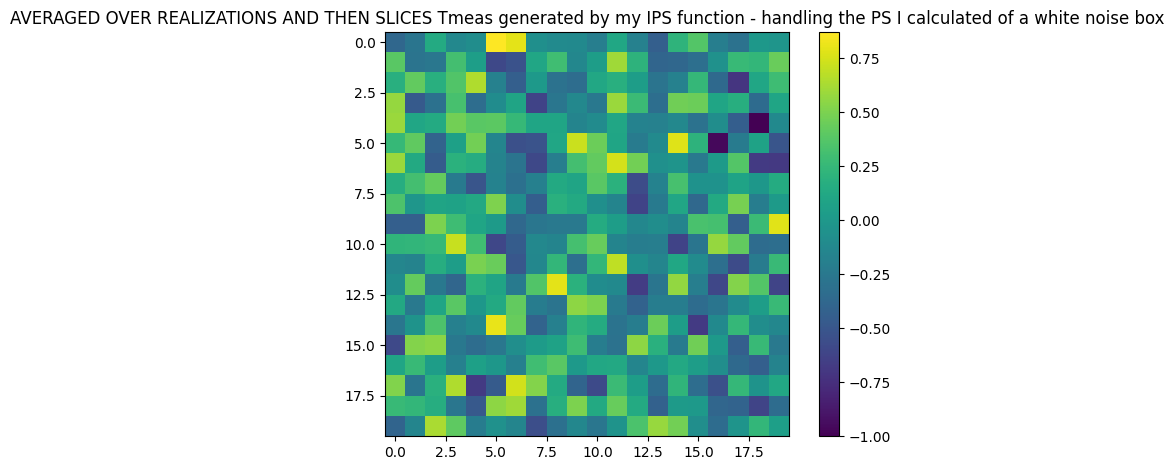

In [9]:
meanTslice=np.mean(meanT,axis=2)
plt.imshow(meanTslice)
plt.colorbar()
plt.title('AVERAGED OVER REALIZATIONS AND THEN SLICES Tmeas generated by my IPS function - handling the PS I calculated of a white noise box')
plt.tight_layout()
plt.show()

In [10]:
nrealiz=20
allTflat=[]
for i in range(nrealiz):
    rgen,Tgen=ips(P,kfl,Lsurvey)
    flatTgen=np.mean(Tgen,axis=2)
    allTflat.append(flatTgen)  
allTflat=np.array(allTflat)
# print('allTflat.shape is',allTflat.shape)
meanT=np.mean(allTflat,axis=2) # average the list of 3D arrays back down into a 2D array
# print('meanT.shape is',meanT.shape)

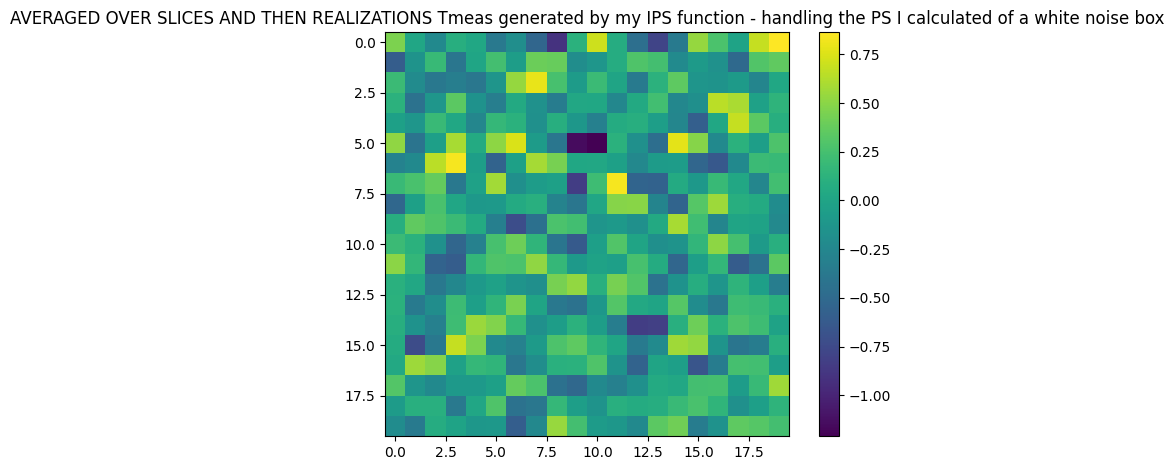

In [11]:
plt.imshow(meanT)
plt.colorbar()
plt.title('AVERAGED OVER SLICES AND THEN REALIZATIONS Tmeas generated by my IPS function - handling the PS I calculated of a white noise box')
plt.tight_layout()
plt.show()